# Clonamos el repositorio para obtener los dataSet

In [1]:
!git clone https://github.com/joanby/tensorflow.git

Cloning into 'tensorflow'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 60311 (delta 32), reused 37 (delta 23), pack-reused 60260
Receiving objects: 100% (60311/60311), 442.46 MiB | 14.75 MiB/s, done.
Resolving deltas: 100% (82/82), done.
Checking out files: 100% (60225/60225), done.


# Damos acceso a nuestro Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Test it

In [ ]:
!ls '/content/drive/My Drive' 

# Google colab tools

In [2]:
from google.colab import files # Para manejar los archivos y, por ejemplo, exportar a su navegador
import glob # Para manejar los archivos y, por ejemplo, exportar a su navegador
from google.colab import drive # Montar tu Google drive

##Especificando la versión de TensorFlow

Ejecutando "importar tensorflow" importará la versión por defecto (actualmente 2.x). Puedes usar la 1.x ejecutando una celda con la "versión mágica de tensorflow" **antes de ejecutar "importar tensorflow".

### Si no funciona hacer el pip install


In [3]:
#!pip install tensorflow==1.14
%tensorflow_version 1.x

TensorFlow 1.x selected.


# Importar Tensorflow

In [6]:
import tensorflow as tf
print(tf.__version__)
import matplotlib.pyplot as plt

1.15.2


In [7]:
session = tf.Session()

# Una red neuronal convolucional simple

- 2 capas de convolucion + ReLU + Max Pooling
- 2 capas totalmente conectadas

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.framework import ops

ops.reset_default_graph()
session = tf.Session()

In [25]:
data_dir = '/content/tensorflow/datasets/MNIST_data'
mnist = input_data.read_data_sets(data_dir, one_hot=False)

Extracting /content/tensorflow/datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting /content/tensorflow/datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /content/tensorflow/datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /content/tensorflow/datasets/MNIST_data/t10k-labels-idx1-ubyte.gz


In [26]:
train_xdata = np.array([np.reshape(x, (28,28)) for x in mnist.train.images])
test_xdata = np.array([np.reshape(x, (28,28)) for x in mnist.test.images])
train_labels = mnist.train.labels
test_labels = mnist.test.labels

In [27]:
batch_size = 100
learning_rate = 0.005
evaluation_size = 500
image_width = train_xdata[0].shape[0]
image_height = train_xdata[0].shape[1]
target_size = max(train_labels)+1
num_chanels = 1
generations = 500
eval_every = 5
conv1_features = 25
conv2_features = 50
max_pool_size1 = 2
max_pool_size2 = 2
full_connected_size1 = 100

In [28]:
x_input_shape = (batch_size, image_width, image_height, num_chanels)
x_input = tf.placeholder(tf.float32, shape = x_input_shape)
y_target = tf.placeholder(tf.int32, shape=(batch_size))

eval_input_shape = (evaluation_size, image_width, image_height, num_chanels)
eval_input = tf.placeholder(tf.float32, shape=eval_input_shape)
eval_target = tf.placeholder(tf.float32, shape = (evaluation_size))

In [29]:
conv1_weight = tf.Variable(tf.truncated_normal([4,4,num_chanels, conv1_features], stddev=0.1, dtype=tf.float32))
conv1_bias = tf.Variable(tf.zeros([conv1_features], dtype=tf.float32))
                    
conv2_weight = tf.Variable(tf.truncated_normal([4,4,conv1_features, conv2_features], stddev=0.1, dtype=tf.float32))
conv2_bias = tf.Variable(tf.zeros([conv2_features], dtype=tf.float32))

In [30]:
resulting_width = image_width // (max_pool_size1*max_pool_size2)
resulting_height = image_height // (max_pool_size1 * max_pool_size2)

full1_input_size = resulting_width*resulting_height*conv2_features
full1_weight = tf.Variable(tf.truncated_normal([full1_input_size, full_connected_size1], stddev=0.1, dtype=tf.float32))
full1_bias = tf.Variable(tf.truncated_normal([full_connected_size1], stddev=0.1, dtype = tf.float32))

full2_weight = tf.Variable(tf.truncated_normal([full_connected_size1, target_size], stddev=0.1, dtype=tf.float32))
full2_bias = tf.Variable(tf.truncated_normal([target_size], stddev=0.1, dtype=tf.float32))

In [31]:
def my_conv_neural_net(input_data):
    ## Primera capa Conv+ReLU+Maxpool
    conv1 = tf.nn.conv2d(input_data, conv1_weight, strides=[1,1,1,1], padding="SAME")
    relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_bias))
    max_pool1 = tf.nn.max_pool(relu1, ksize=[1,max_pool_size1, max_pool_size1,1], 
                               strides=[1, max_pool_size1, max_pool_size1,1], padding="SAME")
    ## Segunda capa Conv+ReLU+Maxpool
    conv2 = tf.nn.conv2d(max_pool1, conv2_weight, strides=[1,1,1,1], padding="SAME")
    relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_bias))
    max_pool2 = tf.nn.max_pool(relu2, ksize=[1,max_pool_size2, max_pool_size2,1], 
                               strides=[1, max_pool_size2, max_pool_size2,1], padding="SAME")
    ## Operación de flattening para aplanar la imagen en un vector
    final_conv_shape = max_pool2.get_shape().as_list()
    final_shape = final_conv_shape[1]*final_conv_shape[2]*final_conv_shape[3]
    flat_output = tf.reshape(max_pool2, [final_conv_shape[0], final_shape])
    ## Tercera capa, totalmente conectada
    fully_connected_1 = tf.nn.relu(tf.add(tf.matmul(flat_output, full1_weight), full1_bias))
    ## Cuarta capa, totalmente conectada
    fully_connected_2 = tf.add(tf.matmul(fully_connected_1, full2_weight), full2_bias)
    return fully_connected_2

In [32]:
model_ouput = my_conv_neural_net(x_input)
test_model_output = my_conv_neural_net(eval_input)

In [33]:
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_ouput, labels = y_target))

In [34]:
prediction = tf.nn.softmax(model_ouput)
test_prediction = tf.nn.softmax(test_model_output)

def get_accuracy(logits, targets):
    batch_predictions = np.argmax(logits, axis = 1)
    num_corrects = np.sum(np.equal(batch_predictions, targets))
    return 100.0*num_corrects/batch_predictions.shape[0]

In [35]:
my_optim = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9)
train_step = my_optim.minimize(loss)

In [36]:
init = tf.global_variables_initializer()
session.run(init)

In [37]:
train_loss = []
train_acc = []
test_acc = []
i_vals = []
for i in range(generations):
    rand_idx = np.random.choice(len(train_xdata), size = batch_size)
    rand_x = train_xdata[rand_idx]
    rand_x = np.expand_dims(rand_x, 3)
    rand_y = train_labels[rand_idx]
    train_dict = {x_input:rand_x, y_target:rand_y}
    session.run(train_step, feed_dict=train_dict)
    temp_train_loss, temp_train_preds = session.run([loss, prediction], feed_dict=train_dict)
    temp_train_acc = get_accuracy(temp_train_preds, rand_y)
    
    if(i+1) % eval_every == 0:
        rand_idx_eval = np.random.choice(len(test_xdata), size = evaluation_size)
        rand_x_eval = test_xdata[rand_idx_eval]
        rand_x_eval = np.expand_dims(rand_x_eval, 3)
        rand_y_eval = test_labels[rand_idx_eval]
        test_dict = {eval_input:rand_x_eval, eval_target:rand_y_eval}

        temp_test_preds = session.run( test_prediction, feed_dict=test_dict)
        temp_test_acc = get_accuracy(temp_test_preds, rand_y_eval)
        
        i_vals.append(i+1)
        train_loss.append(temp_train_loss)
        train_acc.append(temp_train_acc)
        test_acc.append(temp_test_acc)
 
        acc_and_loss = [(i+1),temp_train_loss, temp_train_acc, temp_test_acc]
        acc_and_loss = [np.round(x,3) for x in acc_and_loss]
        print("Iteración {}. Train Loss: {:.3f}. Train Acc: {:.3f}. Test Acc: {:.3f}".format(*acc_and_loss))

Iteración 5. Train Loss: 2.289. Train Acc: 11.000. Test Acc: 11.800
Iteración 10. Train Loss: 2.158. Train Acc: 28.000. Test Acc: 23.400
Iteración 15. Train Loss: 2.097. Train Acc: 32.000. Test Acc: 30.400
Iteración 20. Train Loss: 2.005. Train Acc: 31.000. Test Acc: 45.000
Iteración 25. Train Loss: 1.699. Train Acc: 62.000. Test Acc: 61.200
Iteración 30. Train Loss: 1.501. Train Acc: 60.000. Test Acc: 61.400
Iteración 35. Train Loss: 1.318. Train Acc: 62.000. Test Acc: 69.000
Iteración 40. Train Loss: 0.924. Train Acc: 74.000. Test Acc: 75.600
Iteración 45. Train Loss: 0.771. Train Acc: 78.000. Test Acc: 80.600
Iteración 50. Train Loss: 0.675. Train Acc: 80.000. Test Acc: 81.200
Iteración 55. Train Loss: 0.657. Train Acc: 82.000. Test Acc: 85.000
Iteración 60. Train Loss: 0.464. Train Acc: 88.000. Test Acc: 79.400
Iteración 65. Train Loss: 0.587. Train Acc: 86.000. Test Acc: 87.800
Iteración 70. Train Loss: 0.304. Train Acc: 90.000. Test Acc: 88.800
Iteración 75. Train Loss: 0.389. Tr

## Evaluar la calidad de la red neuronal

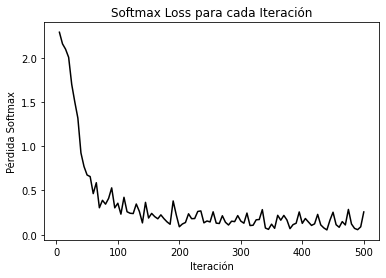

In [38]:
plt.plot(i_vals, train_loss, 'k-')
plt.title("Softmax Loss para cada Iteración")
plt.xlabel("Iteración")
plt.ylabel("Pérdida Softmax")
plt.show()

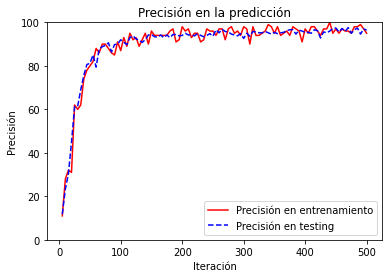

In [39]:
plt.plot(i_vals, train_acc, 'r-', label="Precisión en entrenamiento")
plt.plot(i_vals, test_acc, 'b--', label="Precisión en testing")
plt.xlabel("Iteración")
plt.ylabel("Precisión")
plt.ylim([0,100])
plt.title("Precisión en la predicción")
plt.legend(loc="lower right")
plt.show()

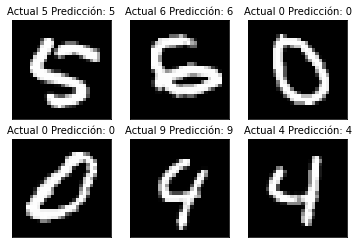

In [40]:
actuals = rand_y[0:6]
predictions = np.argmax(temp_train_preds, axis=1)[0:6]
images = np.squeeze(rand_x[0:6])
nrows = 2
ncols = 3
for i in range(6):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(np.reshape(images[i], [28,28]), cmap="Greys_r")
    plt.title("Actual "+str(actuals[i])+" Predicción: "+str(predictions[i]), fontsize = 10)
    frame=plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)